<a href="https://colab.research.google.com/github/josealvarez97/The-Ultimate-Guide-to-Write-Your-First-CFD-Solver/blob/main/The_Ultimate_Video_Tutorial_to_Write_your_First_CFD_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import your favorite libraries
import numpy as np
from matplotlib import pyplot as plt, cm

In [2]:
# Continuous domain
x_min = 0
x_max = 2
nx = 41 # 41 mesh ****points****
dx = (x_max - x_min) / (nx-1) # 40 divisions

y_min = 0
y_max = 2
ny = 41
dy = (y_max - y_min) / (ny-1)

# Global variables
rho = 1 # density
nu = .1 # viscosity
dt = .001


# Data structures
# Velocities
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
# Pressure
p = np.zeros((ny,nx))

In [3]:
# Boundary conditions
# U TOP
u[ny-1,:] = 1
# U BOTTOM
u[0,:] = 0
# U RIGHT
u[:,nx-1] = 0
# U LEFT
u[:,0] = 0

# V TOP
v[ny-1,:] = 0
# V BOTTOM
v[0,:] = 0
# V RIGHT
v[:,nx-1] = 0
# V LEFT
v[:,0] = 0

In [4]:
def set_pressure_boundary(p):
    # Pressure boundary conditions (Neumann or "second-type")
    '''
    Trick question: Would the approach below break depending on 
    whether you use forward, backward, or centered differences?
    Why or why not?
    '''
    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    # Pressure boundary conditions (Dirichlet or "fixed")
    p[-1, :] = 0        # p = 0 at y = 2

    return p

In [5]:
def diff_1st_x(f):
  return (f[1:-1, 2:] - f[1:-1,0:-2])/(2*dx)

def diff_1st_y(f):
  return (f[2:, 1:-1] - f[0:-2,1:-1])/(2*dy)

# Discretization
def forward_diff_x(f):
  return (f[1:-1,2:] - f[1:-1,1:-1])/dx

def forward_diff_y(f):
  return (f[2:,1:-1] - f[1:-1,1:-1])/dy

def backward_diff_x(f):
  return (f[1:-1,1:-1] - f[1:-1,0:-2])/dx

def backward_diff_y(f):
  return (f[1:-1,1:-1] - f[0:-2,1:-1])/dy

def diff_2nd_x(f):
  # WARNING: Probably not more computationally efficient, 
  # but it should work, and it's pedagogically interesting.
  # return (forward_diff_x(f) - backward_diff_x(f))/dx
  return (
      # f(i-1,j) + 2*f(i,j) + f(i+1,j) 
      (f[1:-1,0:-2] - 2*f[1:-1,1:-1] + f[1:-1,2:])
      /dx**2
      ) 
  
def diff_2nd_y(f):
  # return (forward_diff_y(f) - backward_diff_y(f))/dy
  return (
      # f(i,j-1) + 2*f(i,j) + f(i,j+1) 
      (f[0:-2,1:-1] - 2*f[1:-1,1:-1] + f[2:,1:-1])
      /dy**2
      )

def laplacian(f):
  return diff_2nd_x(f) + diff_2nd_y(f)

In [6]:
# VELOCITY WITHOUT THE INFLUENCE OF THE PRESSURE... 
# ...BECAUSE I DONT KNOW THAT YET :'(
    
def vel_without_pressure(un, vn):
  u_without_pressure = un.copy()
  v_without_pressure = vn.copy()

  u_without_pressure[1:-1,1:-1] = (- (un[1:-1,1:-1]*forward_diff_x(un) + vn[1:-1,1:-1]*forward_diff_y(un)) 
                  + nu*laplacian(un)) * dt + un[1:-1,1:-1]

  v_without_pressure[1:-1,1:-1] = (- (un[1:-1,1:-1]*forward_diff_x(vn) + vn[1:-1,1:-1]*forward_diff_y(vn)) 
                  + nu*laplacian(vn)) * dt + vn[1:-1,1:-1]

  return u_without_pressure, v_without_pressure

In [7]:
# def right_hand_side_pressure_poisson():
def get_R(u_without_pressure, v_without_pressure):
  R = np.zeros((ny,nx))

  def divergence(f):
    '''
    Divergence of scalar-valued (2d, multivariable) function
    '''
    return forward_diff_x(f) + forward_diff_y(f)

  def divergence_vector_valued(f):
    '''
    Divergence of vector-valued (2d, multivariable) function
    '''
    return forward_diff_x(f[0]) + forward_diff_y(f[1])

  
  # divergence_vel_without_pressure = (
  #     forward_diff_x(u_without_pressure) + forward_diff_y(v_without_pressure)
  # )

  R[1:-1,1:-1] = (rho/dt) * divergence_vector_valued((u,v))
  return R


# def solve_pressure_poisson()
def get_pressure(p, R):
  # Δ𝑦2(𝑝𝑛+1(𝑖−1,𝑗)+𝑝𝑛+1(𝑖+1,𝑗))
  term1 = dy**2 * (p[1:-1,0:-2] + p[1:-1,2:])
  # Δ𝑥2(𝑝𝑛+1(𝑖−1,𝑗)+𝑝𝑛+1(𝑖+1,𝑗))
  term2 = dx**2 * (p[0:-2,1:-1] + p[2:,1:-1])
  # −R𝑛(𝑖,𝑗)Δ𝑥2Δ𝑦2
  term3 = -1 * R[1:-1,1:-1] * (dx**2 * dy**2)

  p[1:-1,1:-1] =  (term1 + term2 + term3) / (2*(dy**2 + dx**2))
  set_pressure_boundary(p) # (Don't forget this.)
  return p

In [8]:
def update_velocity(u, v, u_without_pressure, v_without_pressure, p):
  u[1:-1,1:-1] = (-dt/rho) * diff_1st_x(p) + u_without_pressure[1:-1,1:-1]
  v[1:-1,1:-1] = (-dt/rho) * diff_1st_y(p) + v_without_pressure[1:-1,1:-1]

  return u, v

In [9]:
def simulate_cavity_flow(nt, u, v, p):

  for n in range(nt):
    u_without_pressure, v_without_pressure = vel_without_pressure(u,v)

    R = get_R(u_without_pressure, v_without_pressure)

    p = get_pressure(p, R)

    u, v = update_velocity(u, v, u_without_pressure, v_without_pressure, p)

  return u,v,p

In [10]:
simulate_cavity_flow(nt=1000, u=u, v=v, p=p)

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.72113150e-05, -5.03202391e-06, ...,
         -2.04607672e-04, -3.44873922e-05,  0.00000000e+00],
        [ 0.00000000e+00, -6.09725030e-05, -2.23864876e-04, ...,
         -6.43201896e-04, -1.97308235e-04,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  1.31345129e-01,  2.05779372e-01, ...,
          2.02125717e-01,  1.05382754e-01,  0.00000000e+00],
        [ 0.00000000e+00,  3.48875030e-01,  4.42343149e-01, ...,
          3.62165432e-01,  2.50972474e-01,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  0.00000000e+00]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.43710738e-05,  6.85937603e-05, ...,
         -6.97539010e-05,  2.22439005e

In [11]:
x = np.linspace(x_min, x_max, nx)
y = np.linspace(x_min, x_max, nx)

X,Y = np.meshgrid(x,y)

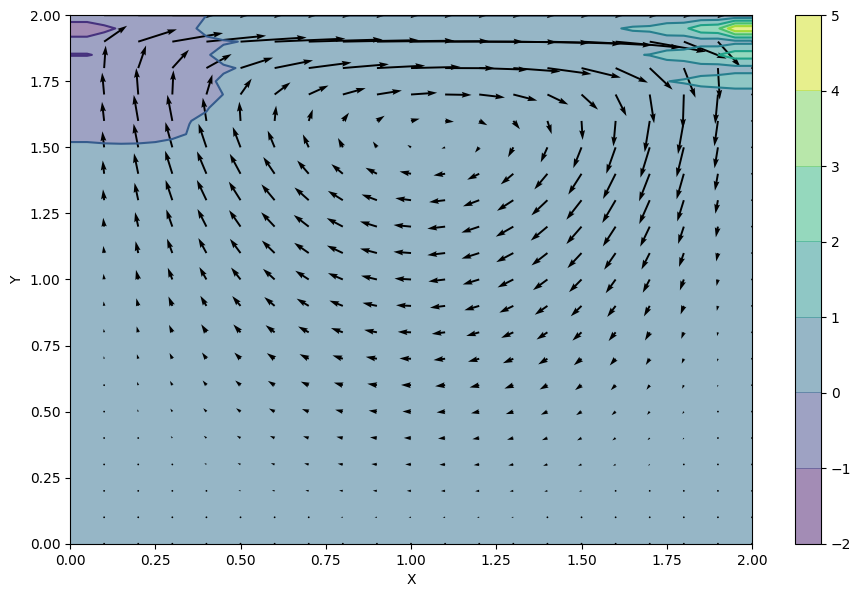

In [12]:
fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('X')
plt.ylabel('Y');

# References:

Owkes, M. (2020). A guide to writing your first CFD solver. Retrieved from https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf

Barba, Lorena A., and Forsyth, Gilbert F. (2018). CFD Python: the 12 steps to Navier-Stokes equations. Journal of Open Source Education, 1(9), 21, https://doi.org/10.21105/jose.00021

Alvarez, J., and Nobe, M. (2021). The Ultimate Guide to Write Your First CFD Solver. Retrieved from https://colab.research.google.com/drive/1gBnKS2dvGsXZqugzm_X7YM5ue40qE6rB